# About this model
### This model includes daily Apple stock statistics, including open price, close price and more for 10 years. If successful the model will give a prediction of the closing price for the given day with a recommendation to buy or sell. I believe this is will be very helpful for day traders that trade once per day. The data can be fetched via yahoo finance, which is included in the code, need to simply run libraries and modules.

# Import Libraries

In [3]:
!pip install yfinance
!pip install pmdarima
!pip install mplfinance

# Install Modules

In [24]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pmdarima as pm
import itertools
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


# Get Data

In [5]:
tickerSymbol = 'AAPL'
tickerData = yf.Ticker(tickerSymbol)
tickerDf = tickerData.history(interval='1d', start='2014-06-01', end='2024-05-15')
tickerDf.to_csv('aapl.csv', sep='\t', encoding='utf-8')

apple_df = tickerDf.copy()
apple_df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2506 entries, 2014-06-02 00:00:00-04:00 to 2024-05-14 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2506 non-null   float64
 1   High          2506 non-null   float64
 2   Low           2506 non-null   float64
 3   Close         2506 non-null   float64
 4   Volume        2506 non-null   int64  
 5   Dividends     2506 non-null   float64
 6   Stock Splits  2506 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 156.6 KB


### Data Cleaning

In [6]:
# Check for missing values
missing_values_per_column = apple_df.isnull().sum()
rows_with_missing_values = apple_df[apple_df.isnull().any(axis=1)]
total_missing_values = missing_values_per_column.sum()

print("Missing values in each column:\n", missing_values_per_column)
print("\nRows with any missing values:\n", rows_with_missing_values)
print("\nTotal number of missing values in the DataFrame:", total_missing_values)


Missing values in each column:
 Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

Rows with any missing values:
 Empty DataFrame
Columns: [Open, High, Low, Close, Volume, Dividends, Stock Splits]
Index: []

Total number of missing values in the DataFrame: 0


### Data Visualization

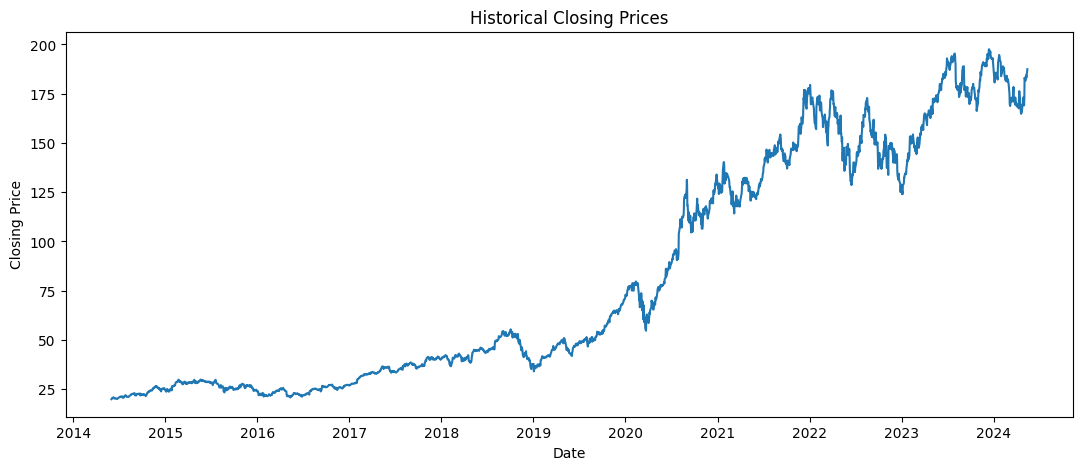

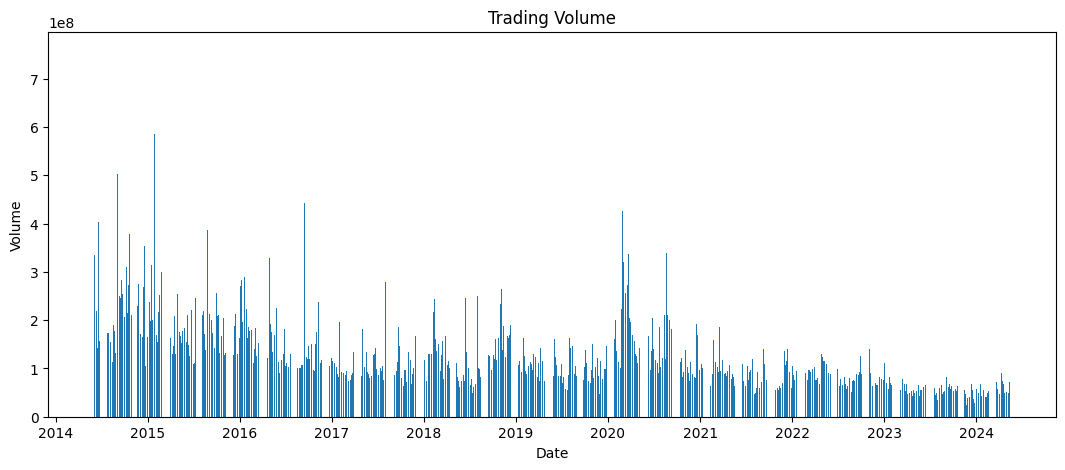

In [7]:
# Visualizing closing prices and trading volumes over time for initial instpection of seazonality. We can see that stock prices are continually increasing
# while sales volume has been decreasing in recent years.

plt.figure(figsize=(13, 5))
plt.plot(apple_df['Close'])
plt.title('Historical Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

plt.figure(figsize=(13, 5))
plt.bar(apple_df.index, apple_df['Volume'])
plt.title('Trading Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

### Feature Engineering

In [8]:
apple_df = tickerDf.drop(columns=['Dividends', 'Stock Splits'])
apple_df['target'] = apple_df['Close'].shift(-1)
apple_df['price_change'] = apple_df['Close'].diff(periods=1)
apple_df['price_change_%'] = apple_df['price_change'] / apple_df['Close'].shift(1) * 100
apple_df.dropna(inplace=True)


# Data Preprocessing

### Making Data stationarity

In [9]:
result = adfuller(apple_df['Close'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -0.030668420423399657
p-value: 0.9559211408301326


### ACF and PACF

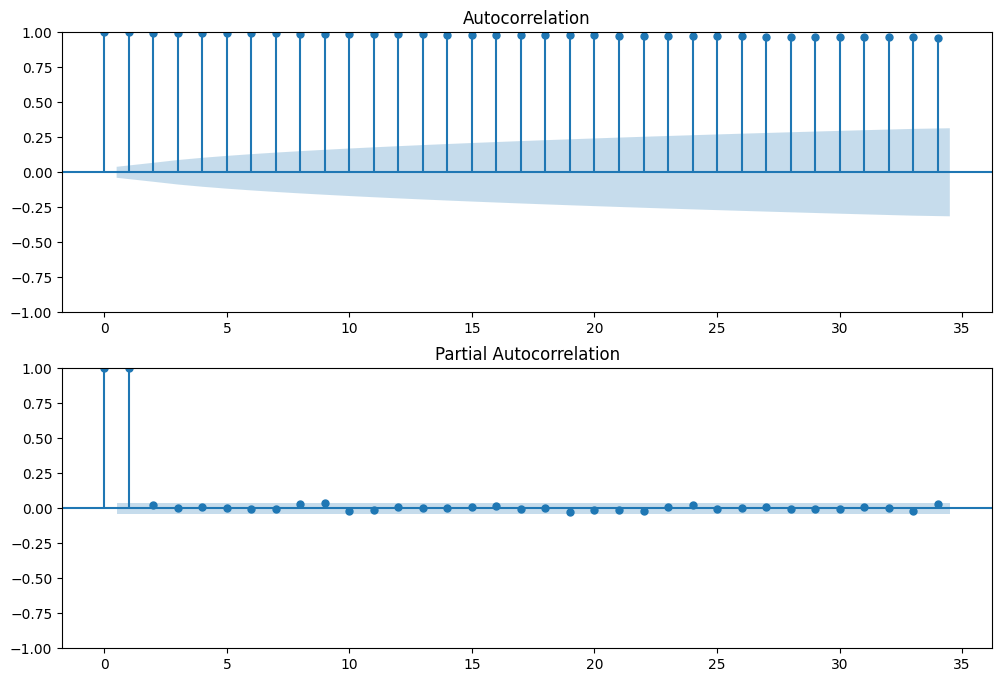

In [10]:
# ACF plot indicates that the time series has strong autocorrelations at multiple lags, implying potential seasonality or a long-term trend.
# PACF plot with two lines indicates that only the first two days have a direct influence on today’s price, independent of each other and other past values.

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(apple_df['Close'].dropna(), ax=ax[0])
plot_pacf(apple_df['Close'].dropna(), ax=ax[1])
plt.show()


### Feature scaling

In [11]:
scaler = StandardScaler()
scaled_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'price_change', 'price_change_%']
apple_df[scaled_columns] = scaler.fit_transform(apple_df[scaled_columns])


### Defining endogenous and exogenous variables

In [12]:
endog = apple_df['target']
exog = apple_df[scaled_columns]


### Splitting data into training and testing sets

In [13]:
train_size = int(len(apple_df) * 0.85)
train_endog = endog.iloc[:train_size]
test_endog = endog.iloc[train_size:]
train_exog = exog.iloc[:train_size]
test_exog = exog.iloc[train_size:]


## Auto-ARIMA

In [14]:
auto_model = pm.auto_arima(train_endog, exogenous=train_exog, seasonal=True, m=2, trace=True, error_action='ignore', suppress_warnings=True)
order = auto_model.order
seasonal_order = auto_model.seasonal_order


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[2] intercept   : AIC=8208.416, Time=6.84 sec
 ARIMA(0,1,0)(0,0,0)[2] intercept   : AIC=8210.334, Time=0.17 sec
 ARIMA(1,1,0)(1,0,0)[2] intercept   : AIC=8204.958, Time=0.94 sec
 ARIMA(0,1,1)(0,0,1)[2] intercept   : AIC=8204.994, Time=0.96 sec
 ARIMA(0,1,0)(0,0,0)[2]             : AIC=8211.113, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[2] intercept   : AIC=8204.455, Time=0.30 sec
 ARIMA(1,1,0)(0,0,1)[2] intercept   : AIC=8204.999, Time=0.79 sec
 ARIMA(1,1,0)(1,0,1)[2] intercept   : AIC=8206.590, Time=2.62 sec
 ARIMA(1,1,1)(0,0,0)[2] intercept   : AIC=8204.416, Time=3.31 sec
 ARIMA(1,1,1)(1,0,0)[2] intercept   : AIC=8206.415, Time=3.82 sec
 ARIMA(1,1,1)(0,0,1)[2] intercept   : AIC=8206.415, Time=3.96 sec
 ARIMA(0,1,1)(0,0,0)[2] intercept   : AIC=8204.053, Time=0.65 sec
 ARIMA(0,1,1)(1,0,0)[2] intercept   : AIC=8204.964, Time=0.95 sec
 ARIMA(0,1,1)(1,0,1)[2] intercept   : AIC=8206.626, Time=2.50 sec
 ARIMA(0,1,1)(0,0,0)[2]          

# SARIMAX model

In [15]:
model = SARIMAX(train_endog, exog=train_exog, order=order, seasonal_order=seasonal_order, enforce_stationarity=True, enforce_invertibility=True)
sarima_fit = model.fit(disp=False)

# Forecast
n_forecast = len(test_endog)
forecast = sarima_fit.get_forecast(steps=n_forecast, exog=test_exog)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()


### Inverse scaling

In [16]:
# Transforming scaled features back to original numbers.

apple_df[scaled_columns] = scaler.inverse_transform(apple_df[scaled_columns])

apple_df['Forecast'] = np.nan
apple_df.iloc[train_size:train_size+n_forecast, apple_df.columns.get_loc('Forecast')] = forecast_mean.values


### Adding forecast to apple_df

In [17]:
apple_df['Forecast'] = np.nan
apple_df.iloc[train_size:train_size+n_forecast, apple_df.columns.get_loc('Forecast')] = forecast_mean.values

### Plotting the forecast

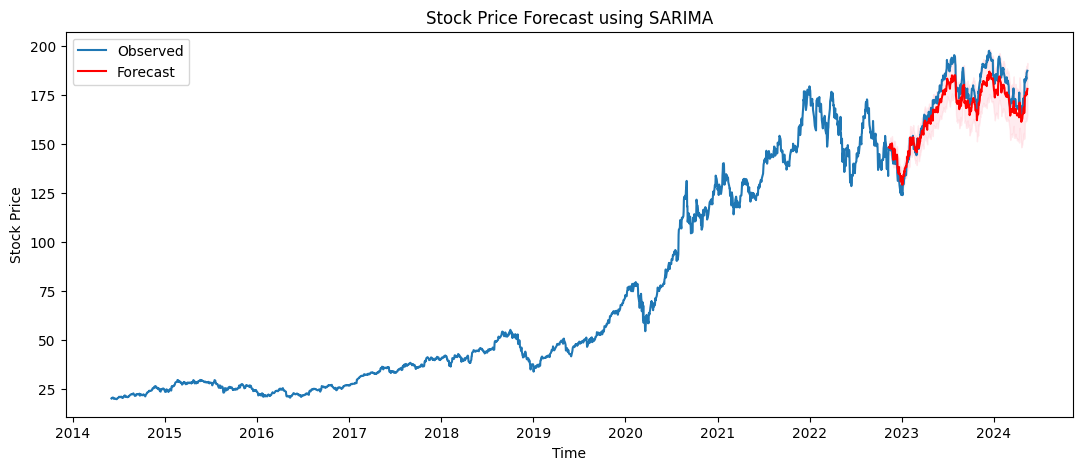

Forecasted Values:
Date
2022-11-11 00:00:00-05:00    148.432082
2022-11-14 00:00:00-05:00    148.078333
2022-11-15 00:00:00-05:00    148.627799
2022-11-16 00:00:00-05:00    148.048936
2022-11-17 00:00:00-05:00    149.952220
                                ...    
2024-05-07 00:00:00-04:00    174.956584
2024-05-08 00:00:00-04:00    174.978545
2024-05-09 00:00:00-04:00    176.684281
2024-05-10 00:00:00-04:00    175.299798
2024-05-13 00:00:00-04:00    178.182947
Name: Forecast, Length: 376, dtype: float64


In [18]:
# Very good visuals for the forecast. The model seems to capture the trend well.

plt.figure(figsize=(13, 5))
plt.plot(apple_df.index, apple_df['target'], label='Observed')
plt.plot(test_endog.index, apple_df.loc[test_endog.index, 'Forecast'], label='Forecast', color='red')
plt.fill_between(test_endog.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Forecast using SARIMA')
plt.legend()
plt.show()

print("Forecasted Values:")
print(apple_df.loc[test_endog.index, 'Forecast'])

### Model Evaluation

In [19]:
# Mean Squared Error (MSE): 35.92, which reflects the average squared difference between predicted and actual values is indicative of reasonable accuracy.
# Mean Absolute Error (MAE): 5.18, suggesting that, on average, the predictions are off by around $5.18.
# Root Mean Squared Error (RMSE): 5.99, indicating sensitivity to large errors but still showing good overall accuracy.
# Mean Absolute Percentage Error (MAPE): 2.95%, meaning the model predictions are off by around 2.95% on average, which is quite good for stock price predictions.
# R-squared (R²): 0.8874, indicating that 88.74% of the variance in the target variable is explained by the model.
#    This is a strong indication of the model's explanatory power.

mse = mean_squared_error(test_endog, forecast_mean)
mae = mean_absolute_error(test_endog, forecast_mean)
rmse = np.sqrt(mse)

test_endog = test_endog.reset_index(drop=True)
forecast_mean = forecast_mean.reset_index(drop=True)
non_zero_mask = test_endog != 0
mape = np.mean(np.abs((test_endog[non_zero_mask] - forecast_mean[non_zero_mask]) / test_endog[non_zero_mask])) * 100
r2 = r2_score(test_endog, forecast_mean)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Percentage Error: {mape}')
print(f'R-squared: {r2}')


Mean Squared Error: 41.612078833207605
Mean Absolute Error: 5.603047314746291
Root Mean Squared Error: 6.450742502472688
Mean Absolute Percentage Error: 3.1843334056120014
R-squared: 0.8695753244686795


In [20]:
apple_df.tail()

,Open,High,Low,Close,Volume,target,price_change,price_change_%,Forecast
Date,,,,,,,,,
2024-05-07 00:00:00-04:00,183.201504,184.649537,181.074400,182.152924,77305800.0,182.492477,0.689041,0.379713,174.956584
2024-05-08 00:00:00-04:00,182.602329,182.822032,181.204216,182.492477,45057100.0,184.320007,0.339554,0.186411,174.978545
2024-05-09 00:00:00-04:00,182.312720,184.409882,181.863333,184.320007,48983000.0,183.050003,1.827530,1.001428,176.684281
2024-05-10 00:00:00-04:00,184.899994,185.089996,182.130005,183.050003,50759500.0,186.279999,-1.270004,-0.689021,175.299798
2024-05-13 00:00:00-04:00,185.440002,187.100006,184.619995,186.279999,72044800.0,187.429993,3.229996,1.764543,178.182947


### Examining Residuals

In [25]:
# This function goes through forecasted stock prices performed on the test dataset to check prediction accuracy for the day. The logic of the fucntion is
#   expressed in the nested if statement. This model predicts next day up or down trends with almost 91% accuracy.

def check_forecast_trends(df):
    mismatch_count = 0
    total_comparisons = 0

    for i in range(1, len(df)):
        if not np.isnan(df['Forecast'].iloc[i]) and not np.isnan(df['Forecast'].iloc[i-1]):
            total_comparisons += 1
            prev_close_price = df['Close'].iloc[i-1]
            current_close_price = df['Close'].iloc[i]
            prev_forecast_price = df['Forecast'].iloc[i-1]
            current_forecast_price = df['Forecast'].iloc[i]

            if (current_close_price > prev_close_price and current_forecast_price < prev_forecast_price) or \
               (current_close_price < prev_close_price and current_forecast_price > prev_forecast_price):
                mismatch_count += 1

    mismatch_percentage = (mismatch_count / total_comparisons) * 100 if total_comparisons > 0 else 0
    return mismatch_count, total_comparisons, mismatch_percentage

mismatch_count, total_comparisons, mismatch_percentage = check_forecast_trends(apple_df)
print(f'Total count of forecast mismatches: {mismatch_count} out of {total_comparisons}')
print(f'Percentage of forecast mismatches: {mismatch_percentage:.2f}%')


Total count of forecast mismatches: 37 out of 375
Percentage of forecast mismatches: 9.87%


### Visualizing Residuals

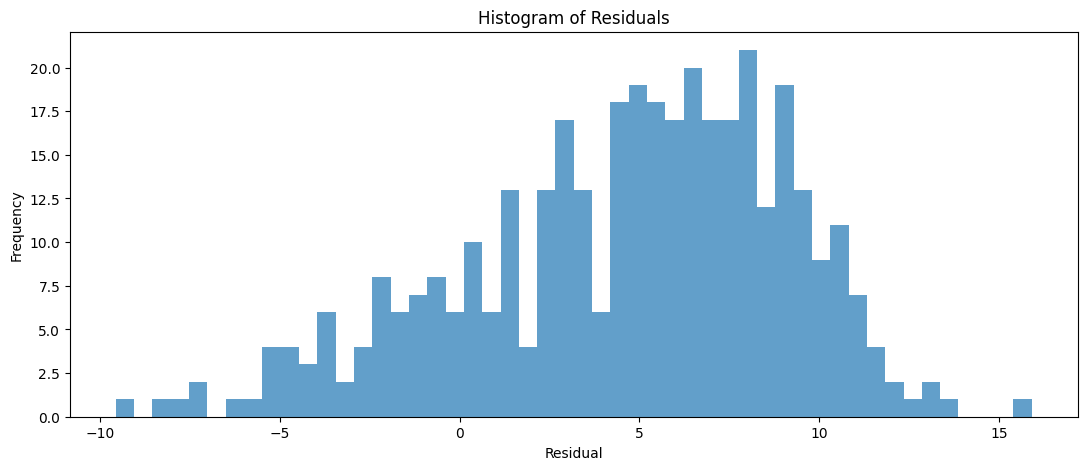

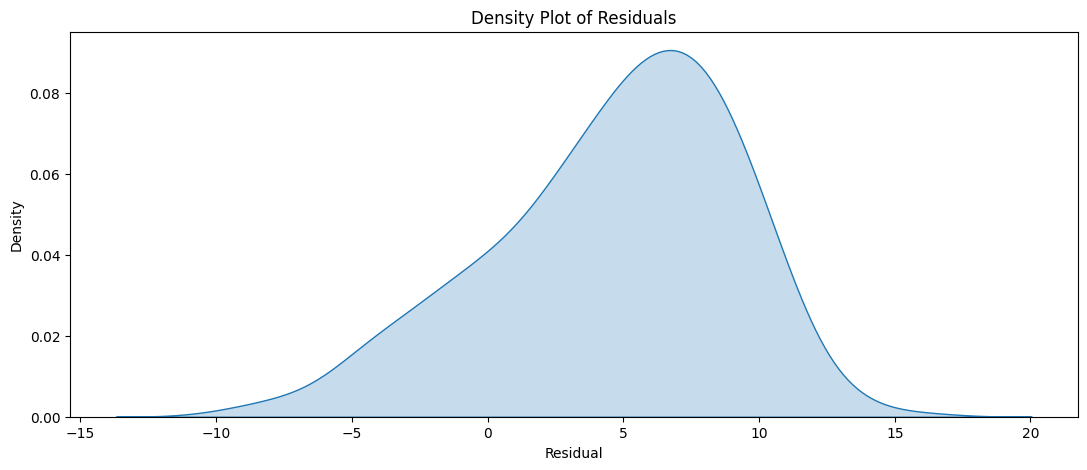

<Figure size 1300x500 with 0 Axes>

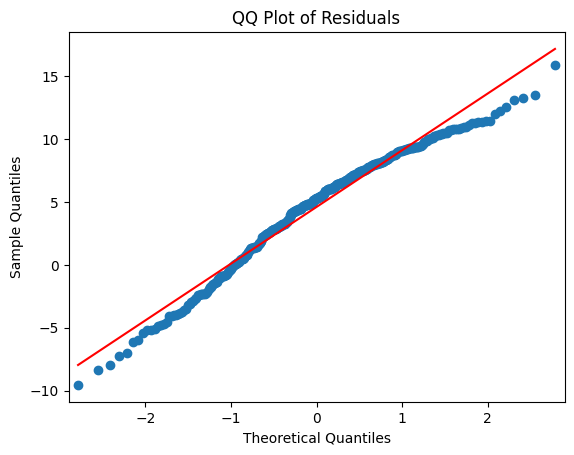

In [22]:
# The histogram and density plot of residuals (the difference between predicted and actual results) indicates no systematic bias and suggests a good fit.
# The QQ plot also suggests that the residuals follow a normal distribution.

residuals = test_endog - forecast_mean

plt.figure(figsize=(13, 5))
plt.hist(residuals, bins=50, alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(13, 5))
sns.kdeplot(residuals, shade=True)
plt.title('Density Plot of Residuals')
plt.xlabel('Residual')
plt.ylabel('Density')
plt.show()

plt.figure(figsize=(13, 5))
qqplot(residuals, line='s')
plt.title('QQ Plot of Residuals')
plt.show()


## Buy/Sell Recommendation

In [23]:
# Added a recommendation columns for the given day. If the stock price is predicted to go up from last day closing to present day closing, the recommendation
#   for the day at the start of day is 'Buy', and if the price is predicted to go down for the day compared to previous day, the recommendation is 'Sell'.

def add_recommendation(df):
    df['Recommendation'] = np.nan

    non_nan_forecast_indices = df[df['Forecast'].notna()].index
    if len(non_nan_forecast_indices) < 2:
        raise ValueError("Not enough non-NaN forecast rows to generate recommendations.")

    for i in range(1, len(non_nan_forecast_indices)):
        current_index = non_nan_forecast_indices[i]
        previous_index = non_nan_forecast_indices[i - 1]
        if df.loc[current_index, 'Forecast'] > df.loc[previous_index, 'Forecast']:
            df.loc[current_index, 'Recommendation'] = 'Buy'
        else:
            df.loc[current_index, 'Recommendation'] = 'Sell'
    return df

apple_df_final = add_recommendation(apple_df)
apple_df_final.tail(50)


,Open,High,Low,Close,Volume,target,price_change,price_change_%,Forecast,Recommendation
Date,,,,,,,,,,
2024-03-04 00:00:00-05:00,175.911389,176.660373,173.554585,174.862823,81510100.0,169.889572,-4.553833,-2.538133,169.310434,Sell
2024-03-05 00:00:00-05:00,170.528705,171.806970,169.390249,169.889572,95132400.0,168.890915,-4.973251,-2.844087,166.144792,Sell
2024-03-06 00:00:00-05:00,170.828290,171.008054,168.451508,168.890915,68587700.0,168.771088,-0.998657,-0.587827,164.569944,Sell
2024-03-07 00:00:00-05:00,168.920878,170.498740,168.261784,168.771088,71765100.0,170.498734,-0.119827,-0.070950,165.159218,Buy
2024-03-08 00:00:00-05:00,168.771081,173.464712,168.711165,170.498734,76114600.0,172.516006,1.727646,1.023662,166.981566,Buy
2024-03-11 00:00:00-04:00,172.705752,174.143803,171.816958,172.516006,60139500.0,172.995346,2.017273,1.183160,167.780066,Buy
2024-03-12 00:00:00-04:00,172.915453,173.794265,170.778352,172.995346,59825400.0,170.898209,0.479340,0.277852,167.379284,Sell
2024-03-13 00:00:00-04:00,172.535987,172.955416,170.528699,170.898209,52488700.0,172.765671,-2.097137,-1.212251,166.331407,Sell
2024-03-14 00:00:00-04:00,172.675796,174.073894,171.816961,172.765671,72913500.0,172.386185,1.867462,1.092734,167.921750,Buy


# Conclusion
### Overall this model is performing excellent explaining over 98% variance in daily closing rates. The further steps would be connecting the model to live data and making informed buying decisions.